In [57]:
import requests
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go

pd.set_option('display.max_rows', None)

%matplotlib inline

In [66]:
MULTIPLIER = 3.5
ROLLING_PERIOD=10

In [67]:
def generate_super_trend_for_ticker(symbol, start_date='2000-01-01', end_date='2022-08-30'):
    ticker_data = yf.Ticker(symbol).history(period="max")
    ticker_data = ticker_data.loc[start_date:end_date]
    
    # calculate high low 
    ticker_data = generate_average_true_range(ticker_data, ROLLING_PERIOD)
    ticker_data = generate_basic_bands(ticker_data, MULTIPLIER)
    ticker_data = generate_final_bands(ticker_data, ROLLING_PERIOD)
    
    return ticker_data

In [68]:
def generate_average_true_range(ticker_data, rolling_period=14):
    
    # calculate high - low difference
    ticker_data['high-low'] = ticker_data['High'] - ticker_data['Low']
    
    # calculate high - previous close 
    ticker_data['Previous Close'] = ticker_data['Close'].shift(1)
    ticker_data['high-previous_close'] = ticker_data['High'] - ticker_data['Previous Close']
    
    # calculate low - previous close
    ticker_data['low-previous_close'] = ticker_data['Low'] - ticker_data['Previous Close']
    
    # calculate true range
    ticker_data['true_range'] = ticker_data[['high-low', 'high-previous_close', 'low-previous_close']].max(axis=1)
    
    # calculate average true range
    ticker_data['average_true_range'] = ticker_data['true_range'].rolling(window=rolling_period).mean()
    
    return ticker_data

In [69]:
def generate_basic_bands(ticker_data, multiplier):
    ticker_data['high_low_avg'] = (ticker_data['High'] + ticker_data['Low']) / 2
    ticker_data['lower_band'] = ticker_data['high_low_avg'] - (multiplier * ticker_data['average_true_range'])
    ticker_data['higher_band'] = ticker_data['high_low_avg'] + (multiplier * ticker_data['average_true_range'])
    
    return ticker_data

In [70]:
def generate_final_bands(ticker_data, rolling_period):
    # initialization values 
    start_index = rolling_period
    
    final_upper_band = [ticker_data.iloc[i]['higher_band'] for i in range(0, start_index)]
    final_lower_band = [ticker_data.iloc[i]['lower_band'] for i in range(0, start_index)]
    super_trend = [ticker_data.iloc[i]['higher_band'] for i in range(0, start_index)]
    
    buy_or_sell = [None for i in range(0, start_index)]
    
    for i in range(start_index, len(ticker_data.index)):
        current = i
        previous = i - 1

        current_basic_upper_band = ticker_data.iloc[current]['higher_band']
        current_basic_lower_band = ticker_data.iloc[current]['lower_band']
        current_close = ticker_data.iloc[current]['Close']

        previous_final_upper_band = final_upper_band[-1]
        previous_final_lower_band = final_lower_band[-1]
        previous_super_trend = super_trend[-1]
        previous_close = ticker_data.iloc[previous]['Close']

        if current_basic_upper_band < previous_final_upper_band or previous_close > previous_final_upper_band:
            final_upper_band.append(current_basic_upper_band)
        else:
            final_upper_band.append(previous_final_upper_band)


        if current_basic_lower_band > previous_final_lower_band or previous_close < previous_final_lower_band:
            final_lower_band.append(current_basic_lower_band)
        else:
            final_lower_band.append(previous_final_lower_band)


        current_final_upper_band = final_upper_band[-1]
        current_final_lower_band = final_lower_band[-1]

        if previous_super_trend == previous_final_upper_band and current_close < current_final_upper_band:
            buy_or_sell.append(False)
            super_trend.append(current_final_upper_band)

        elif previous_super_trend == previous_final_upper_band and current_close > current_final_upper_band:
            buy_or_sell.append(True)
            super_trend.append(current_final_lower_band)

        elif previous_super_trend == previous_final_lower_band and current_close > current_final_lower_band:
            buy_or_sell.append(True)
            super_trend.append(current_final_lower_band)

        elif previous_super_trend == previous_final_lower_band and current_close < current_final_lower_band:
            buy_or_sell.append(False)
            super_trend.append(current_final_upper_band)

    ticker_data['super_trend'] = super_trend
    ticker_data['final_higher_band'] = final_upper_band
    ticker_data['final_lower_band'] = final_lower_band
    ticker_data['buy_or_sell'] = buy_or_sell
    
    ticker_data = ticker_data.iloc[1:]
    return ticker_data

In [71]:
def chart_super_trend(super_trend_df):
    # get buy/sell lines 
    buys_line = []
    sells_line = []

    for i in range(0, len(super_trend_df.index)):
        value = super_trend_df.iloc[i]['super_trend']
        if super_trend_df.iloc[i]['buy_or_sell']:
            buys_line.append(value)
            sells_line.append(None)
        else:
            sells_line.append(value)
            buys_line.append(None)
        
    # extract data for candles
    candlestick = go.Candlestick(
        name='candles',
        x=super_trend_df.index,
        open=super_trend_df['Open'],
        high=super_trend_df['High'],
        low=super_trend_df['Low'],
        close=super_trend_df['Close']
    )

    # extract data for lower & higher bands
    lower_band = go.Line(
        name='lower_band',
        x=super_trend_df.index,
        y=super_trend_df['lower_band'],
        line=dict(color="purple"),
    )

    higher_band = go.Line(
        name='higher_band',
        x=super_trend_df.index,
        y=super_trend_df['higher_band'],
        line=dict(color="purple"),
    )

    # extract data for final bands
    final_upper_band_line = go.Line(
        name='final_upper_band',
        x=super_trend_df.index,
        y=super_trend_df['final_higher_band'],
        line=dict(color='green'),
    )

    final_lower_band_line = go.Line(
        name='final_lower_band',
        x=super_trend_df.index,
        y=super_trend_df['final_lower_band'],
        line=dict(color='red'),
    )

    # extract data for super trend overall line
    super_trend_line = go.Line(
        name='super_trend_line',
        x=super_trend_df.index,
        y=super_trend_df['super_trend'],
        line=dict(color='black')
    )

    buy_line = go.Scatter(
        name='buy_line',
        x=super_trend_df.index,
        y=buys_line,
        line=dict(color='purple')
    )

    sell_line = go.Scatter(
        name='sell_line',
        x=super_trend_df.index,
        y=sells_line,
        line=dict(color='pink')
    )

    fig = go.Figure(
        data=[candlestick, final_upper_band_line, final_lower_band_line, super_trend_line, buy_line, sell_line]
    )
    
    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,)

    fig.show()

In [99]:
ticker = 'VTI'
start_date='2001-05-24'
end_date='2022-09-04'

super_trend_df = generate_super_trend_for_ticker(ticker, start_date, end_date)
super_trend_df.head(30)

Open       High        Low      Close   Volume  Dividends  \
Date                                                                         
2001-06-18  37.987745  38.055806  37.644043  37.644043   282600       0.00   
2001-06-19  38.215743  38.225952  37.592993  37.749531  1777600       0.00   
2001-06-20  37.688258  38.164679  37.688258  38.147663   476000       0.00   
2001-06-21  38.113641  38.607075  38.028566  38.453941   240400       0.00   
2001-06-22  38.419937  38.419937  38.028591  38.208950   180600       0.00   
2001-06-25  38.277165  38.338572  37.792731  37.963306    30400       0.14   
2001-06-26  37.560737  38.055407  37.547090  37.864361   146600       0.00   
2001-06-27  37.936008  38.099762  37.686969  37.867779   114000       0.00   
2001-06-28  38.140698  38.679714  38.140698  38.331741   357400       0.00   
2001-06-29  38.225987  38.761594  38.178226  38.550079   215000       0.00   
2001-07-02  38.413609  38.870753  38.413609  38.652416   290000       0.00   
2001-07-03  38.601256  38.669485  38.492087  38.631958    56800       0.00   
2001-07-05  38.512551  38.529609  38.191868  38.191868   627600       0.00   
2001-07-06  37.867773  37.895066  37.185471  37.185471   777000       0.00   
2001-07-09  37.332180  37.594865  37.287831  37.424290   850000       0.00   
2001-07-10  37.615322  37.632378  36.929607  36.929607   218000       0.00   
2001-07-11  36.997851  37.021731  36.591883  36.977383    47200       0.00   
2001-07-12  37.338980  37.898467  37.335570  37.854118    64800       0.00   
2001-07-13  37.663093  38.120234  37.628978  38.034946   430000       0.00   
2001-07-16  38.055397  38.055397  37.553905  37.594841    46400       0.00   
2001-07-17  37.526626  38.038353  37.437926  38.038353   183400       0.00   
2001-07-18  37.714249  37.898468  37.495912  37.642605    54400       0.00   
2001-07-19  38.123628  38.290791  37.697189  37.854118    18600       0.00   
2001-07-20  37.867774  37.966708  37.697199  37.857540    11600       0.00   
2001-07-23  37.953065  38.000826  37.202534  37.202534    52000       0.00   
2001-07-24  37.072897  37.199124  36.434946  36.687397   102400       0.00   
2001-07-25  36.741980  37.165010  36.660105  37.151363   519200       0.00   
2001-07-26  37.076300  37.625553  36.977366  37.625553    65000       0.00   
2001-07-27  37.652846  37.813184  37.437919  37.690372   208000       0.00   
2001-07-30  37.799564  37.799564  37.495940  37.659691    25600       0.00   

            Stock Splits  high-low  Previous Close  high-previous_close  \
Date                                                                      
2001-06-18           0.0  0.411763       37.885639             0.170167   
2001-06-19           0.0  0.632959       37.644043             0.581909   
2001-06-20           0.0  0.476421       37.749531             0.415148   
2001-06-21           0.0  0.578510       38.147663             0.459412   
2001-06-22           0.0  0.391346       38.453941            -0.034004   
2001-06-25           0.0  0.545841       38.208950             0.129622   
2001-06-26           0.0  0.508317       37.963306             0.092101   
2001-06-27           0.0  0.412793       37.864361             0.235401   
2001-06-28           0.0  0.539017       37.867779             0.811936   
2001-06-29           0.0  0.583368       38.331741             0.429853   
2001-07-02           0.0  0.457144       38.550079             0.320673   
2001-07-03           0.0  0.177397       38.652416             0.017069   
2001-07-05           0.0  0.337741       38.631958            -0.102349   
2001-07-06           0.0  0.709595       38.191868            -0.296802   
2001-07-09           0.0  0.307034       37.185471             0.409395   
2001-07-10           0.0  0.702770       37.424290             0.208088   
2001-07-11           0.0  0.429849       36.929607             0.092124   
2001-07-12           0.0  0.562897       36.977383             0.921084   
2001-07-13          

/Users/vaibhav/projects/antifragile/venv/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




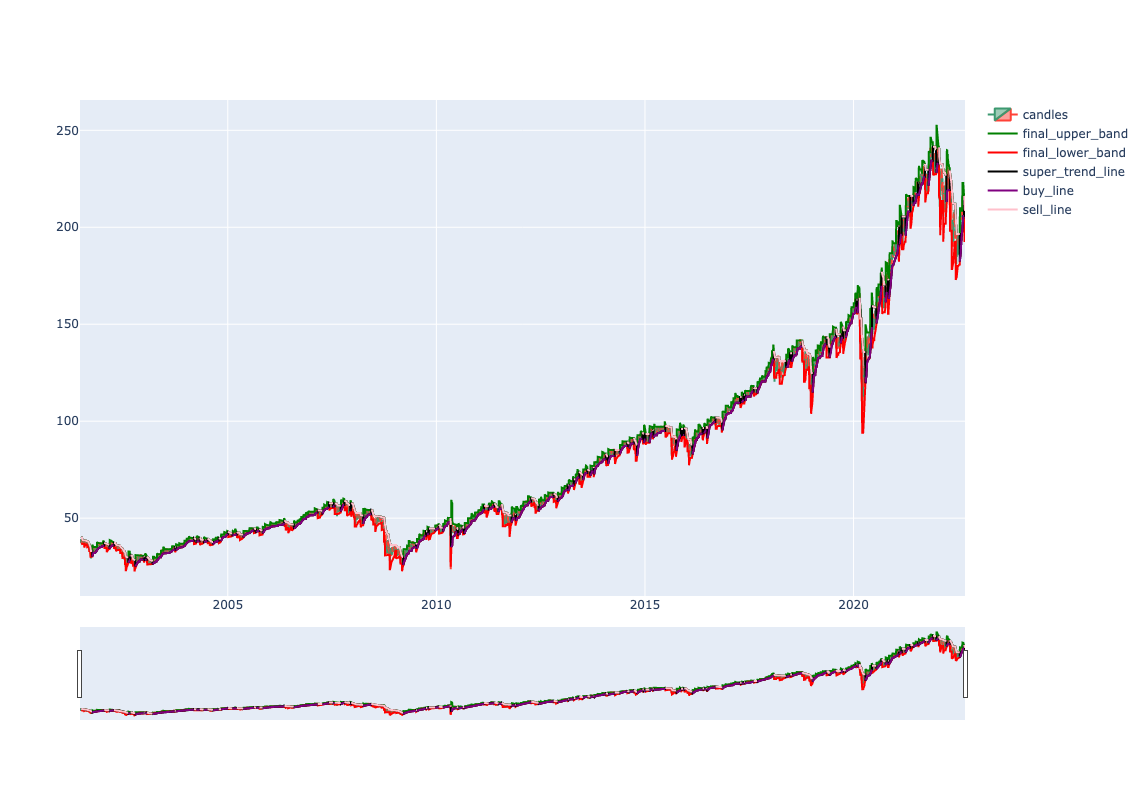

In [100]:
chart_super_trend(super_trend_df)

In [101]:
def simulate_portfolio_on_strategy(super_trend_df, initial_amt=10000):
    logs = []
    portfolio_vals = [initial_amt]
    percent_differences = [0.0]
    buying = False
    
    for i in range(1, len(super_trend_df.index)):
        current = i
        previous = i - 1
        current_trade = super_trend_df.iloc[current]['buy_or_sell']
        previous_trade = super_trend_df.iloc[previous]['buy_or_sell']
        
        # buy order
        if previous_trade == False and current_trade == True:
#             buy_price = super_trend_df.iloc[current]['Close']
            buying = True
            
        # sell order
        elif previous_trade == True and current_trade == False:
#             sell_price = super_trend_df.iloc[current]['Close']
#             percent_difference = (sell_price - buy_price) / buy_price
#             initial_amt = initial_amt * (1 + percent_difference)
            buying = False
            
        raw_percent_difference = 0
        if buying:
            previous_price = super_trend_df.iloc[previous]['Close']
            current_price = super_trend_df.iloc[current]['Close']
            raw_percent_difference = ((current_price - previous_price) / current_price)
        else:
            raw_percent_difference = 0
            
        percent_difference = 1 + raw_percent_difference
        initial_amt = initial_amt * percent_difference

        percent_differences.append(raw_percent_difference * 100)
        portfolio_vals.append(initial_amt)
            
    return portfolio_vals, percent_differences

In [102]:
INITIAL_AMOUNT = 10000
portfolio_over_time, percent_differences = simulate_portfolio_on_strategy(super_trend_df, INITIAL_AMOUNT)

super_trend_df['portfolio_values'] = portfolio_over_time
super_trend_df['percentage_change'] = percent_differences
# super_trend_df.head(len(super_trend_df.index))

In [103]:
def benchmark_strategy(super_trend_df, benchmark_ticker='VTI', initial_amt=INITIAL_AMOUNT):
    start_date = super_trend_df.iloc[0].name
    end_date = super_trend_df.iloc[-1].name
    print(f"start date: {start_date}")
    print(f"end date: {end_date}", "\n")

    # get benchmark data & calculate portfolio change by simply holding
    benchmark_df = yf.Ticker(benchmark_ticker).history(period="max")
    benchmark_df = benchmark_df[start_date:end_date]

    benchmark_percent_differences = [0.0]
    b_portfolio_values = [INITIAL_AMOUNT]

    for i in range(1, len(benchmark_df.index)):
        current = i
        previous = i - 1

        current_portfolio_value = benchmark_df.iloc[current]['Close']
        previous_portfolio_value = benchmark_df.iloc[previous]['Close']

        raw_percent_difference = (current_portfolio_value - previous_portfolio_value) / previous_portfolio_value
        percent_difference = 1 + raw_percent_difference

        b_previous_portfolio_value = b_portfolio_values[-1]
        b_portfolio_values.append(percent_difference * b_previous_portfolio_value)
        benchmark_percent_differences.append(raw_percent_difference * 100)
        
    benchmark_df['portfolio_values'] = b_portfolio_values
    benchmark_df['percentage_change'] = benchmark_percent_differences

    # get strategy principal & total values
    total_return = super_trend_df.loc[end_date]['portfolio_values']
    b_total_return = benchmark_df.loc[end_date]['portfolio_values']
    
    # get benchmark principal & total values
    principal = benchmark_df.loc[start_date]['portfolio_values']
    b_principal = benchmark_df.loc[start_date]['portfolio_values']

    # cumulative return
    cumulative_return = ((total_return - principal) / principal)
    cumulative_return = cumulative_return * 100

    # get benchmark cumulative return
    b_cumulative_return = ((b_total_return - b_principal) / b_principal)
    b_cumulative_return = b_cumulative_return * 100

    # annual return
    num_years_invested = int(((end_date - start_date).days) / 365)
    annual_return = ((total_return/principal) ** (1/num_years_invested)) - 1
    annual_return = annual_return * 100

    # benchmark annual return
    num_years_invested = int(((end_date - start_date).days) / 365)
    b_annual_return = ((b_total_return/b_principal) ** (1/num_years_invested)) - 1
    b_annual_return = b_annual_return * 100
    
    # annual volatility
    percent_differences = list(super_trend_df['percentage_change'].values)
    mean = sum(percent_differences) / len(percent_differences)
    variance = sum([((x - mean) ** 2) for x in percent_differences]) / len(percent_differences)
    volatility = variance ** 0.5

    # benchmark annual volatility    
    b_mean = sum(benchmark_percent_differences) / len(benchmark_percent_differences)
    b_variance = sum([((x - b_mean) ** 2) for x in benchmark_percent_differences]) / len(benchmark_percent_differences)
    b_volatility = b_variance ** 0.5
    
    # sharpe ratio
    treasury_rate = 3.5
    sharpe_ratio = (annual_return - treasury_rate) / variance

    # benchmark sharpe ratio
    b_sharpe_ratio = (b_annual_return - treasury_rate) / b_variance
    
    # calmar ratio
    portfolio_values = super_trend_df['portfolio_values'].values
    max_portfolio_val = max(portfolio_values)
    min_portfolio_val = min(portfolio_values)
    drawdown = (max_portfolio_val - min_portfolio_val) / (max_portfolio_val)
    calmar_ratio = (annual_return - treasury_rate) / drawdown

    # benchmark calmar ratio
    b_portfolio_values = benchmark_df['portfolio_values'].values
    b_max_portfolio_val = max(b_portfolio_values)
    b_min_portfolio_val = min(b_portfolio_values)
    b_drawdown = (b_max_portfolio_val - b_min_portfolio_val) / b_max_portfolio_val
    b_calmar_ratio = (b_annual_return - treasury_rate) / b_drawdown
    
    benchmark_comparison_dict = {
        'principal' : [INITIAL_AMOUNT, INITIAL_AMOUNT],
        'total_return' : [total_return, b_total_return],
        'cumulative_return' : [cumulative_return, b_cumulative_return],
        'annual_return': [annual_return, b_annual_return],
        'volatility': [volatility, b_volatility],
        'sharpe_ratio': [sharpe_ratio, b_sharpe_ratio],
        'calmar_ratio': [calmar_ratio, b_calmar_ratio]
    }

    # creating a Dataframe object from dictionary 
    # with custom indexing
    benchmark_comparison_df = pd.DataFrame(benchmark_comparison_dict, index = ['strategy', 'benchmark',])
    return benchmark_comparison_df, benchmark_df

In [104]:
benchmark_comparison_df, benchmark_df = benchmark_strategy(super_trend_df)
benchmark_comparison_df.head(5)

start date: 2001-06-18 00:00:00
end date: 2022-09-02 00:00:00 



principal   total_return  cumulative_return  annual_return  \
strategy       10000  227734.344326        2177.343443      16.048479   
benchmark      10000   52255.302814         422.553028       8.192382   

           volatility  sharpe_ratio  calmar_ratio  
strategy     0.650809     29.626752     13.108927  
benchmark    1.230097      3.101090      5.241047

In [105]:
def visualize_benchmark_against_strategy(super_trend_df, benchmark_df):
    benchmark_line = go.Line(
        name='benchmark_VTI',
        x=benchmark_df.index,
        y=benchmark_df['portfolio_values'],
        line=dict(color='red'),
    )

    strategy_line = go.Line(
        name=f'super_trend_strategy_{ticker}',
        x=super_trend_df.index,
        y=super_trend_df['portfolio_values'],
        line=dict(color='green'),
    )

    fig = go.Figure(
        data=[benchmark_line, strategy_line]
    )

    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,)

    fig.show()

/Users/vaibhav/projects/antifragile/venv/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




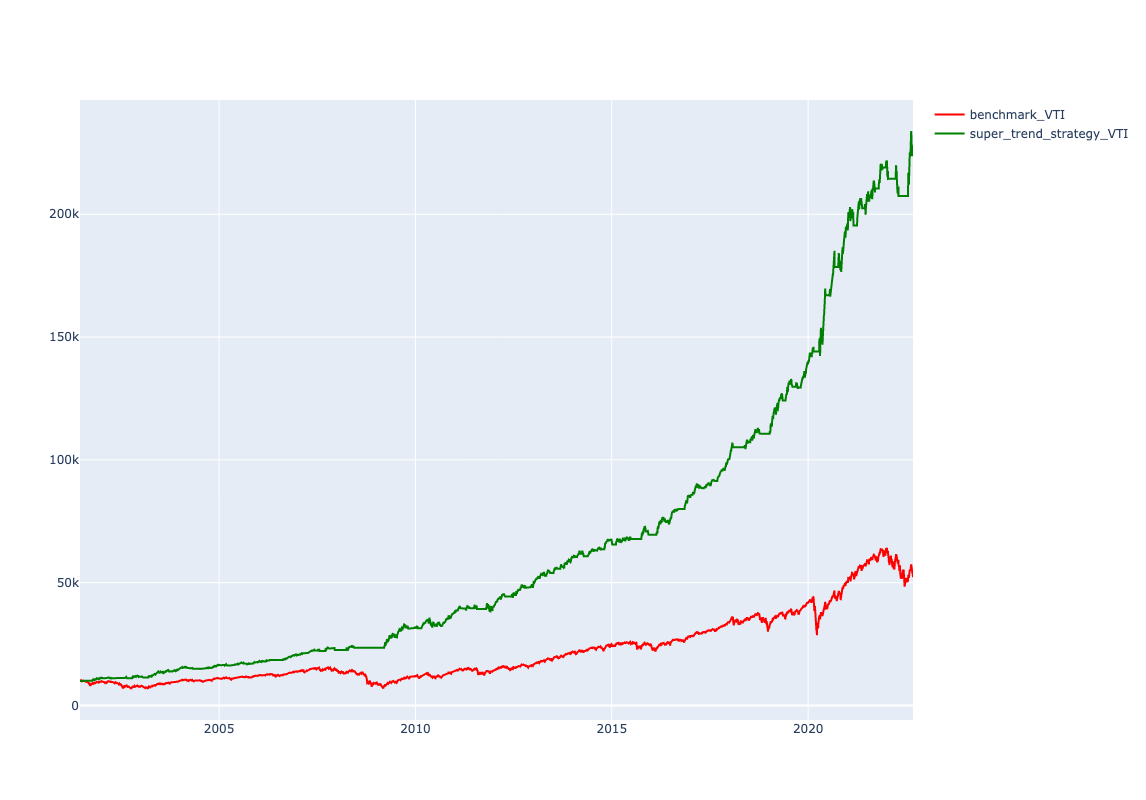

In [106]:
visualize_benchmark_against_strategy(super_trend_df, benchmark_df)

In [107]:
close_price = benchmark_df.iloc[-1]['Close']
open_price = benchmark_df.iloc[0]['Close']

In [115]:
str(super_trend_df.iloc[-1].name.date())

'2022-09-02 00:00:00'

In [ ]:
str(super_trend_df.iloc[-1].name.date())

In [125]:
import json
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [127]:
dummy_data = yf.Ticker(ticker).history(period="max")
dummy_data.iloc[-1]

Open            1.957300e+02
High            1.999400e+02
Low             1.956400e+02
Close           1.995300e+02
Volume          3.031400e+06
Dividends       0.000000e+00
Stock Splits    0.000000e+00
Name: 2022-09-07 00:00:00, dtype: float64

In [128]:
dummy_data.to_pickle('./dummy')

TypeError: file must have a 'write' attribute